## Introduction

In this project, we aim to assist a company specializing in small to mid-size apartment rentals, hosting 2-6 guests, by developing a price prediction model for new apartments not yet on the market.

We employ a dataset from Airbnb listings to construct four sophisticated models: OLS linear regression, OLS with Lasso regularization, Random Forest, and Gradient Boosting Machines (GBM).

Our objective is not only to predict apartment prices accurately but also to delve into the factors influencing these prices, enhancing our understanding of the real estate market.

In [254]:
# importing libraries

import os
import sys
import warnings
from patsy import dmatrices
from py_helper_functions import *
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from statsmodels.api import OLS
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor



from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer

from plotnine import ggplot, aes, geom_point, geom_segment, coord_flip, theme_bw, scale_y_continuous
from mizani.formatters import percent_format
from sklearn.inspection import permutation_importance

# ignore warnings
warnings.filterwarnings("ignore")
# turn off scientific notation
# pd.set_option("display.float_format", lambda x: "%.2f" % x)
# show all columns
pd.set_option('display.max_columns',None)
# show all rows
pd.set_option('display.max_rows',None)



### Initial Setup
In this section, we prepare our environment by importing the necessary libraries and setting configurations to ensure our analysis runs smoothly. This includes libraries for data manipulation, visualization, statistical modeling, and custom functions from our `py_helper_functions.py` file to aid in our analysis. Since the data was too large to upload to GitHub, we split it into 6 parts, read it from there, and then combined it into a single listings DataFrame. Loading can take about a minute.

In [2]:
# List to hold the dataframes
dfs = []

# Loop through the range of numbers and format the filename
for i in range(1, 7):
    filename = f'https://raw.githubusercontent.com/artyomashigov/da3/main/da3_assignment2/listings_part{i}.csv'
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all the dataframes into one
listings_full = pd.concat(dfs, ignore_index=True)
listings_full.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36978719,https://www.airbnb.com/rooms/36978719,20230903194229,2023-09-04,previous scrape,Home in Alhambra · 1 bedroom · 1 bed · 1 bath,NaN,NaN,https://a0.muscache.com/pictures/7d2f2cda-fa0e...,278008181,https://www.airbnb.com/users/show/278008181,Shiela,2019-07-21,NaN,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/a364f...,https://a0.muscache.com/im/pictures/user/a364f...,NaN,3.0,6.0,['phone'],t,f,NaN,South Pasadena,Other Cities,34.102710,-118.145170,Private room in home,Private room,1,NaN,1 bath,NaN,1.0,"[""Free parking on premises"", ""Smoke alarm"", ""C...",$90.00,6,90,6,6,90,90,6.0,90.0,NaN,f,0,0,0,0,2023-09-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,3,0,2,1,NaN
1,930487087555321292,https://www.airbnb.com/rooms/930487087555321292,20230903194229,2023-09-04,previous scrape,Home in La Puente · ★New · 1 bedroom · 1 bed ·...,Take a break and unwind at this peaceful oasis.,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,482579539,https://www.airbnb.com/users/show/482579539,Yahide,2022-10-07,"Rowland Heights, CA",I hope I can provide guests good Airbnb experi...,within an hour,96%,98%,f,https://a0.muscache.com/im/pictures/user/31845...,https://a0.muscache.com/im/pictures/user/31845...,NaN,16.0,28.0,"['email', 'phone']",t,t,NaN,Rowland Heights,Unincorporated Areas,33.979625,-117.880993,Private room in home,Private room,2,NaN,3 baths,NaN,1.0,"[""Lock on bedroom door"", ""Wifi""]",$35.00,1,10,1,1,10,10,1.0,10.0,NaN,t,0,0,0,0,2023-09-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,9,0,9,0,NaN
2,942342470598573002,https://www.airbnb.com/rooms/942342470598573002,20230903194229,2023-09-04,city scrape,Home in Rowland Heights · ★New · 1 bedroom · 2...,在这处宁静房源中，与全家人尽情放松。,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,495867643,https://www.airbnb.com/users/show/495867643,Lin,2023-01-13,"Los Angeles, CA",专业管理团队,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/d1230...,https://a0.muscache.com/im/pictures/user/d1230...,NaN,5.0,7.0,"['email', 'phone']",t,f,NaN,Rowland Heights,Unincorporated Areas,33.978508,-117.898650,Private room in home,Private room,4,NaN,1 bath,1.0,2.0,"[""Free parking on premises"", ""Washer"", ""Air co...",$69.00,1,365,1,1,365,365,1.0,365.0,NaN,t,24,54,84,359,2023-09-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,4,0,4,0,NaN


### Data Cleaning
We're going to clean our data by keeping only the columns that are relevant to us and have less than 30% missing data. We'll also change the types of some columns and drop any rows where the price is missing.

In [150]:
# filter only properties from 2 to 6 accommodates
listings = listings_full[(listings_full['accommodates']<=6) & (listings_full['accommodates']>=2)]

# calculate missing values percentage for all columns
missing_percentage = listings.isnull().mean() * 100

# filter columns that have less than 30% missing values
columns_to_keep = missing_percentage[missing_percentage < 30].index.tolist()

# keep only the filtered columns
listings = listings[columns_to_keep]

# drop the rows when the price is null
listings.dropna(subset=['price'], inplace = True)

In [151]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,picture_url,host_id,host_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1,930487087555321292,https://www.airbnb.com/rooms/930487087555321292,20230903194229,2023-09-04,previous scrape,Home in La Puente · ★New · 1 bedroom · 1 bed ·...,Take a break and unwind at this peaceful oasis.,https://a0.muscache.com/pictures/hosting/Hosti...,482579539,https://www.airbnb.com/users/show/482579539,Yahide,2022-10-07,"Rowland Heights, CA",within an hour,96%,98%,f,https://a0.muscache.com/im/pictures/user/31845...,https://a0.muscache.com/im/pictures/user/31845...,NaN,16.0,28.0,"['email', 'phone']",t,t,Rowland Heights,Unincorporated Areas,33.979625,-117.880993,Private room in home,Private room,2,3 baths,NaN,1.0,"[""Lock on bedroom door"", ""Wifi""]",$35.00,1,10,1,1,10,10,1.0,10.0,t,0,0,0,0,2023-09-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,9,0,9,0,NaN
2,942342470598573002,https://www.airbnb.com/rooms/942342470598573002,20230903194229,2023-09-04,city scrape,Home in Rowland Heights · ★New · 1 bedroom · 2...,在这处宁静房源中，与全家人尽情放松。,https://a0.muscache.com/pictures/miso/Hosting-...,495867643,https://www.airbnb.com/users/show/495867643,Lin,2023-01-13,"Los Angeles, CA",within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/d1230...,https://a0.muscache.com/im/pictures/user/d1230...,NaN,5.0,7.0,"['email', 'phone']",t,f,Rowland Heights,Unincorporated Areas,33.978508,-117.898650,Private room in home,Private room,4,1 bath,1.0,2.0,"[""Free parking on premises"", ""Washer"", ""Air co...",$69.00,1,365,1,1,365,365,1.0,365.0,t,24,54,84,359,2023-09-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,4,0,4,0,NaN


In [152]:
listings.shape

(33760, 69)

host_response_rate, host_acceptance_rate,price

boolean: host_is_superhost(boolean), host_identity_verified, host_has_profile_pic,has_availability, instant_bookable,

extract bathrooms_text, 

In [153]:
listings.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_thumbnail_url                              

### Data Transformation

We will transform the dataset's values to appropriate types.
- The host_response_rate, host_acceptance_rate, and price columns will be converted to float types. 
- The host_is_superhost, host_identity_verified, host_has_profile_pic, has_availability, and instant_bookable columns will be converted to boolean types. 
- Additionally, we'll extract the number of bathrooms from the `bathrooms_text` column.

In [154]:
# Convert percentages to floats
listings['host_response_rate'] = listings['host_response_rate'].str.rstrip('%').astype('float') / 100.0
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

# Convert price to float
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# filter only properties with price less than or equal to 10000. By that we are removing too big extreme few values
listings = listings[listings['price']<=10000]

# Convert to boolean
boolean_columns = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic', 'has_availability', 'instant_bookable']
listings[boolean_columns] = listings[boolean_columns].replace({'t': 1, 'f': 0})

In [155]:
# Extract bathroom numbers
listings['bathrooms'] = listings['bathrooms_text'].str.extract('(\d+)').astype(float)

In [156]:
listings.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_response_time                               object
host_response_rate                              float64
host_acceptance_rate                            float64
host_is_superhost                               float64
host_thumbnail_url                              

In [157]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33756 entries, 1 to 44593
Data columns (total 70 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            33756 non-null  int64  
 1   listing_url                                   33756 non-null  object 
 2   scrape_id                                     33756 non-null  int64  
 3   last_scraped                                  33756 non-null  object 
 4   source                                        33756 non-null  object 
 5   name                                          33756 non-null  object 
 6   description                                   33335 non-null  object 
 7   picture_url                                   33756 non-null  object 
 8   host_id                                       33756 non-null  int64  
 9   host_url                                      33756 non-null  obje

In [158]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'picture_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_

In [159]:
# Remove URLs, IDs, and unique identifiers
listings.drop(['id', 'listing_url','picture_url','scrape_id', 'last_scraped', 'source', 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url'], axis=1, inplace=True)

# Remove text descriptions and names
listings.drop(['name', 'description', 'host_name', 'host_since', 'host_location', 'host_neighbourhood', 'neighbourhood_group_cleansed'], axis=1, inplace=True)

# Remove bathrooms text since we have integer number now
listings.drop(['bathrooms_text'], axis = 1, inplace = True)

# Remove precise location data
listings.drop(['latitude', 'longitude'], axis=1, inplace=True)

# Remove reviews_per_month because it won't give information for new properties
listings.drop(['reviews_per_month'], axis=1, inplace=True)

# Remove host-specific information not directly related to property value
listings.drop(['host_response_time', 'host_verifications'], axis=1, inplace=True)

# Remove date columns
listings.drop(['calendar_last_scraped', 'first_review', 'last_review'], axis=1, inplace=True)

# Removing 'amenities' column
listings.drop(['amenities'], axis=1, inplace=True) 

In [160]:
listings.shape

(33756, 43)

In [161]:
listings.isna().sum()

host_response_rate                              7274
host_acceptance_rate                            6871
host_is_superhost                                741
host_listings_count                                2
host_total_listings_count                          2
host_has_profile_pic                               2
host_identity_verified                             2
neighbourhood_cleansed                             0
property_type                                      0
room_type                                          0
accommodates                                       0
bedrooms                                        9483
beds                                             356
price                                              0
minimum_nights                                     0
maximum_nights                                     0
minimum_minimum_nights                             0
maximum_minimum_nights                             0
minimum_maximum_nights                        

We are going to use imputatations for missing values

In [162]:
# Impute missing values
# For numerical columns we decide to use median
listings['host_response_rate'].fillna(listings['host_response_rate'].median(), inplace=True)
listings['host_acceptance_rate'].fillna(listings['host_acceptance_rate'].median(), inplace=True)
listings['bedrooms'].fillna(listings['bedrooms'].median(), inplace=True)
listings['beds'].fillna(listings['beds'].median(), inplace=True)
listings['bathrooms'].fillna(listings['bathrooms'].median(), inplace=True)

# For review scores we decide to use median
review_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]
for column in review_columns:
    listings[column].fillna(listings[column].median(), inplace=True)

# Create binary indicators for missing values
listings['missing_host_is_superhost'] = listings['host_is_superhost'].isnull().astype(int)
listings['missing_host_has_profile_pic'] = listings['host_has_profile_pic'].isnull().astype(int)
listings['missing_host_identity_verified'] = listings['host_identity_verified'].isnull().astype(int)

# Fill missing values using most frequent values for each
listings['host_is_superhost'].fillna(0, inplace=True)
listings['host_has_profile_pic'].fillna(1, inplace=True)  # Assuming the most hosts have a profile pic
listings['host_identity_verified'].fillna(1, inplace=True)

# Dropping rows where 'host_listings_count' and 'host_total_listings_count' might be missing
listings.dropna(subset=['host_listings_count', 'host_total_listings_count'], inplace=True)

# After imputation, check the dataset for any remaining missing values
listings.isnull().sum()

host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
property_type                                   0
room_type                                       0
accommodates                                    0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0


In [163]:
listings.shape

(33754, 46)

In [164]:
listings.property_type.value_counts()

property_type
Entire rental unit                    10965
Entire home                            6693
Private room in home                   3851
Entire guesthouse                      2396
Entire condo                           1704
Private room in rental unit            1426
Entire guest suite                     1229
Entire bungalow                         567
Entire serviced apartment               514
Entire townhouse                        482
Entire loft                             397
Room in hotel                           356
Private room in condo                   345
Private room in townhouse               292
Room in boutique hotel                  274
Private room in villa                   245
Private room in guest suite             199
Entire villa                            180
Entire cottage                          164
Camper/RV                               158
Private room in bed and breakfast       129
Private room in bungalow                119
Tiny home         

In [165]:
listings.room_type.value_counts()

room_type
Entire home/apt    25912
Private room        7522
Shared room          252
Hotel room            68
Name: count, dtype: int64

In [166]:
# Update the mapping with more specific categories and a 'Unique Stays' category
property_type_mapping = {
    'Entire rental unit': 'Entire_Place',
    'Entire home': 'Entire_Place',
    'Entire guesthouse': 'Entire_Guesthouse',
    'Entire condo': 'Entire_Condo',
    'Private room in home': 'Private_Room',
    'Private room in rental unit': 'Private_Room',
    'Private room in condo': 'Private_Room',
    'Private room in townhouse': 'Private_Room',
    'Private room in guesthouse': 'Private_Room',
    # Group all shared rooms
    'Shared room in home': 'Shared_Room',
    'Shared room in rental unit': 'Shared_Room',
    # More specific categories
    'Entire guest suite': 'Entire_Guesthouse',
    'Entire bungalow': 'Entire_Bungalow',
    'Entire townhouse': 'Entire_Townhouse',
    'Entire loft': 'Entire_Loft',
    # Unique stays
    'Boat': 'Unique_Stays',
    'Treehouse': 'Unique_Stays',
    'Camper/RV': 'Unique_Stays',
    # Default for any type not explicitly mapped
    'Other': 'Other'
}

# Ensure all property types are covered by adding a default 'Other' category for unmapped types
listings['broad_property_type'] = listings['property_type'].apply(lambda x: property_type_mapping.get(x, 'Other'))

# Check the distribution of the new broad_property_type categories
print(listings['broad_property_type'].value_counts())

broad_property_type
Entire_Place         17658
Private_Room          6025
Entire_Guesthouse     3625
Other                 2933
Entire_Condo          1704
Entire_Bungalow        567
Entire_Townhouse       482
Entire_Loft            397
Shared_Room            184
Unique_Stays           179
Name: count, dtype: int64


In [167]:
# Create dummy variables for 'broad_property_type'
dummies = pd.get_dummies(listings['broad_property_type'], prefix='type').astype(int)

# Join the dummy variables back to the original DataFrame
listings = pd.concat([listings, dummies], axis=1)

In [168]:
listings.isna().sum()

host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
property_type                                   0
room_type                                       0
accommodates                                    0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0


### adding dummies for neighborhood

In [170]:
# Determine the top N neighborhoods (e.g., N=20)
top_n = listings['neighbourhood_cleansed'].value_counts().nlargest(20).index

# Create a new column for simplified neighborhood, where non-top neighborhoods are labeled as 'Other'
# And replace whitespace with underscores to ensure proper column names for dummies
listings['simplified_neighbourhood'] = listings['neighbourhood_cleansed'].apply(lambda x: x.replace(' ', '_') if x in top_n else 'Other')

# Create dummy variables for the simplified neighborhood
neighbourhood_dummies = pd.get_dummies(listings['simplified_neighbourhood'], prefix='neighbourhood').astype(int)

# Join the dummy variables back to the original DataFrame
listings = pd.concat([listings, neighbourhood_dummies], axis=1)

In [171]:
listings.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,bathrooms,missing_host_is_superhost,missing_host_has_profile_pic,missing_host_identity_verified,broad_property_type,type_Entire_Bungalow,type_Entire_Condo,type_Entire_Guesthouse,type_Entire_Loft,type_Entire_Place,type_Entire_Townhouse,type_Other,type_Private_Room,type_Shared_Room,type_Unique_Stays,simplified_neighbourhood,neighbourhood_Alhambra,neighbourhood_Beverly_Hills,neighbourhood_Burbank,neighbourhood_Culver_City,neighbourhood_Downtown,neighbourhood_Glendale,neighbourhood_Hollywood,neighbourhood_Hollywood_Hills,neighbourhood_Inglewood,neighbourhood_Koreatown,neighbourhood_Long_Beach,neighbourhood_Mid-Wilshire,neighbourhood_Other,neighbourhood_Pasadena,neighbourhood_Pico-Robertson,neighbourhood_Rowland_Heights,neighbourhood_Santa_Monica,neighbourhood_Silver_Lake,neighbourhood_Venice,neighbourhood_West_Hollywood,neighbourhood_Westlake
1,0.96,0.98,0.0,16.0,28.0,1.0,1.0,Rowland Heights,Private room in home,Private room,2,1.0,1.0,35.0,1,10,1,1,10,10,1.0,10.0,1,0,0,0,0,0,0,0,4.89,4.92,4.88,4.96,4.97,4.9,4.8,0,9,0,9,0,3.0,0,0,0,Private_Room,0,0,0,0,0,0,0,1,0,0,Rowland_Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1.00,1.00,0.0,5.0,7.0,1.0,0.0,Rowland Heights,Private room in home,Private room,4,1.0,2.0,69.0,1,365,1,1,365,365,1.0,365.0,1,24,54,84,359,0,0,0,4.89,4.92,4.88,4.96,4.97,4.9,4.8,1,4,0,4,0,1.0,0,0,0,Private_Room,0,0,0,0,0,0,0,1,0,0,Rowland_Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1.00,0.75,0.0,2.0,2.0,1.0,1.0,Playa del Rey,Entire condo,Entire home/apt,2,1.0,1.0,120.0,30,1125,30,30,1125,1125,30.0,1125.0,1,26,56,86,361,1,0,0,5.00,5.00,5.00,5.00,5.00,5.0,5.0,0,1,1,0,0,1.0,0,0,0,Entire_Condo,0,1,0,0,0,0,0,0,0,0,Other,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0.00,0.98,0.0,1.0,1.0,1.0,0.0,Beverly Hills,Private room in condo,Private room,4,1.0,2.0,450.0,1,365,1,1,1125,1125,1.0,1125.0,1,30,60,90,180,0,0,0,4.89,4.92,4.88,4.96,4.97,4.9,4.8,0,1,0,1,0,1.0,0,0,0,Private_Room,0,0,0,0,0,0,0,1,0,0,Beverly_Hills,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.44,0.47,0.0,91.0,99.0,1.0,1.0,Bell,Private room in home,Private room,2,1.0,1.0,80.0,1,365,1,1,365,365,1.0,365.0,1,30,60,90,364,0,0,0,4.89,4.92,4.88,4.96,4.97,4.9,4.8,0,91,15,76,0,2.0,0,0,0,Private_Room,0,0,0,0,0,0,0,1,0,0,Other,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### adding transformations

In [172]:
# Logarithmic transformations for positively skewed distributions
listings['log_number_of_reviews'] = np.log1p(listings['number_of_reviews'])
listings['log_availability_365'] = np.log1p(listings['availability_365'])

# addding log_price
listings['log_price'] = np.log1p(listings['price'])


# Polynomial features for variables to capture non-linear relationships
listings['accommodates_squared'] = listings['accommodates'] ** 2
listings['bedrooms_squared'] = listings['bedrooms'] ** 2
listings['beds_squared'] = listings['beds'] ** 2

# Interaction terms to capture combined effects of variables on price
listings['accommodates_x_bedrooms'] = listings['accommodates'] * listings['bedrooms']

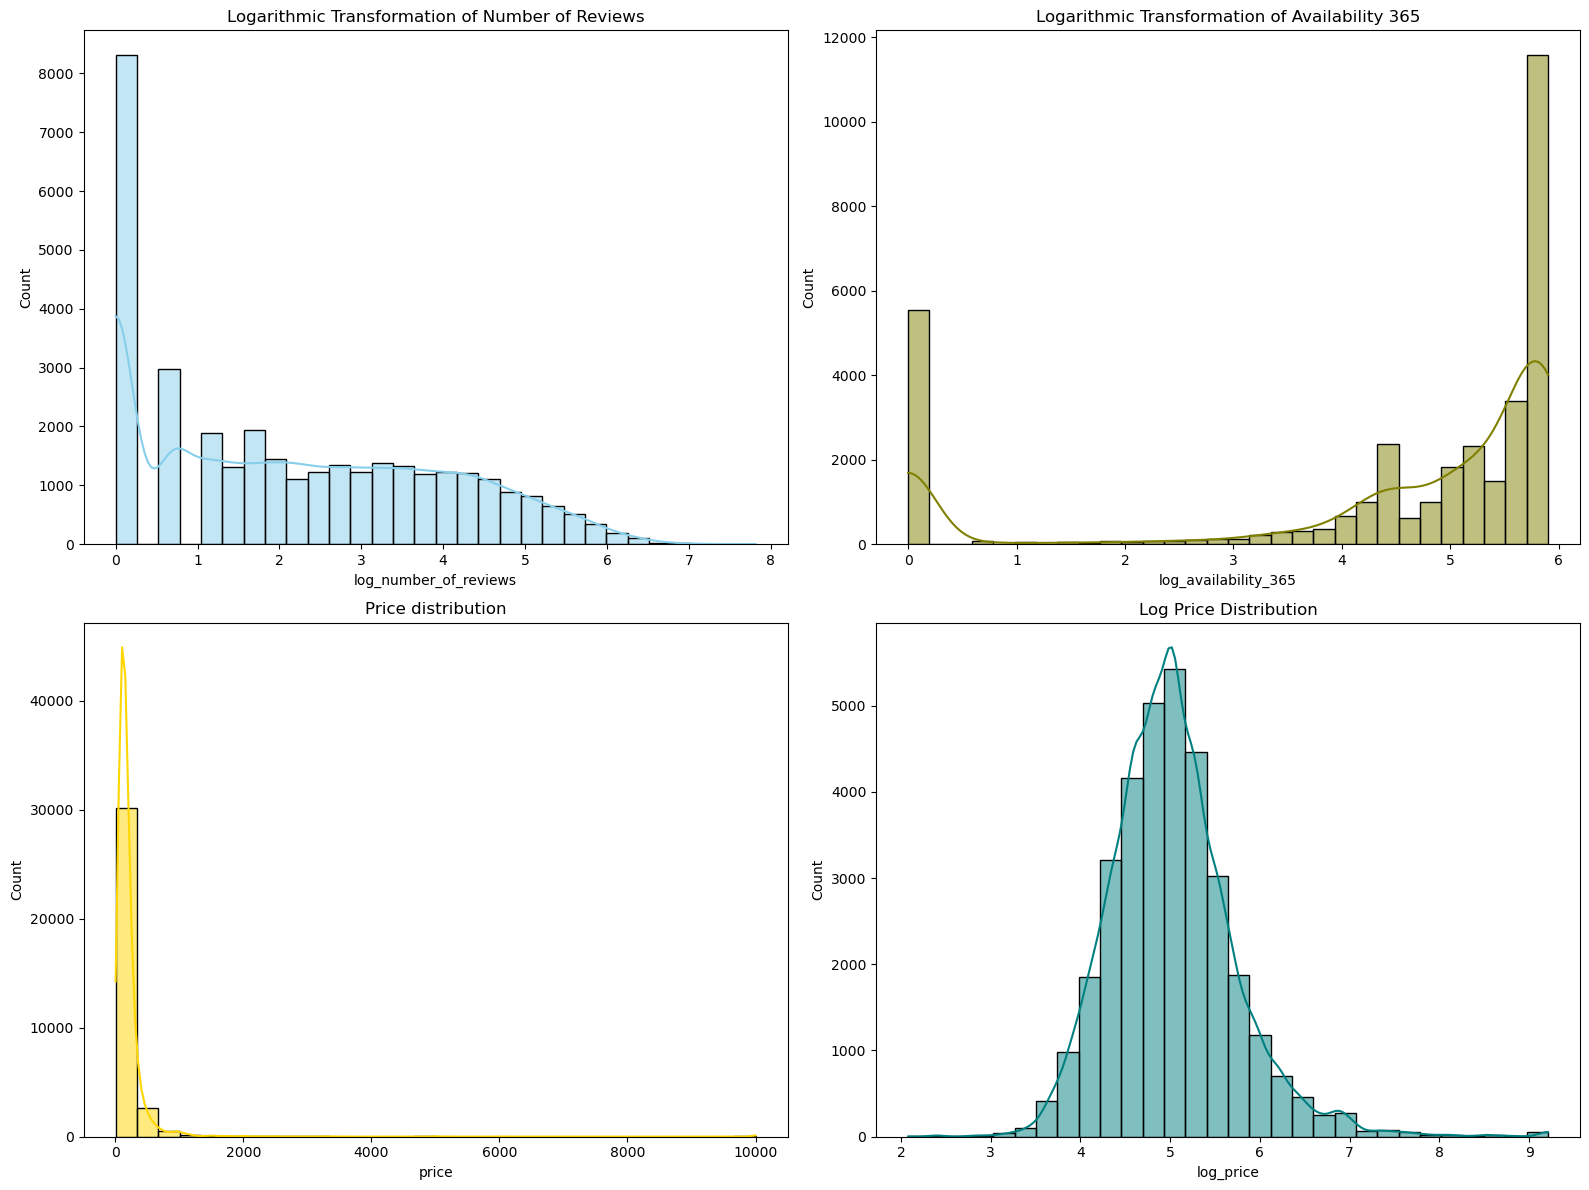

In [173]:
# Plotting the distributions
plt.figure(figsize=(16, 12))

# Logarithmic transformation of number_of_reviews
plt.subplot(2, 2, 1)
sns.histplot(listings['log_number_of_reviews'], kde=True, bins=30, color='skyblue')
plt.title('Logarithmic Transformation of Number of Reviews')

# Logarithmic transformation of availability_365
plt.subplot(2, 2, 2)
sns.histplot(listings['log_availability_365'], kde=True, bins=30, color='olive')
plt.title('Logarithmic Transformation of Availability 365')

# Squared transformation of accommodates
plt.subplot(2, 2, 3)
sns.histplot(listings['price'], kde=True, bins=30, color='gold')
plt.title('Price distribution')

# Interaction of accommodates and bedrooms
plt.subplot(2, 2, 4)
sns.histplot(listings['log_price'], kde=True, bins=30, color='teal')
plt.title('Log Price Distribution')

plt.tight_layout() # Adjusts subplot params to give specified padding
plt.show()

In [174]:
listings.shape

(33754, 86)

In [175]:
listings.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_li

In [176]:
listings.groupby("accommodates").agg(
    mean_price=("price", np.mean),
    min_price=("price", np.min),
    max_price=("price", np.max),
    n=("price", "size"),
)

,mean_price,min_price,max_price,n
accommodates,,,,
2,164.332928,10.0,10000.0,15628
3,161.122078,10.0,6500.0,3465
4,225.516993,10.0,10000.0,7915
5,253.596745,7.0,3500.0,2212
6,380.417733,10.0,9500.0,4534


In [177]:
listings.dtypes

host_response_rate                              float64
host_acceptance_rate                            float64
host_is_superhost                               float64
host_listings_count                             float64
host_total_listings_count                       float64
host_has_profile_pic                            float64
host_identity_verified                          float64
neighbourhood_cleansed                           object
property_type                                    object
room_type                                        object
accommodates                                      int64
bedrooms                                        float64
beds                                            float64
price                                           float64
minimum_nights                                    int64
maximum_nights                                    int64
minimum_minimum_nights                            int64
maximum_minimum_nights                          

### Model building

In [204]:
formula = """
log_price ~ host_response_rate + host_acceptance_rate + host_is_superhost + host_listings_count
            + host_total_listings_count + host_has_profile_pic + host_identity_verified
            + C(neighbourhood_cleansed) + C(property_type) + C(room_type) 
            + accommodates + I(accommodates ** 2) + bedrooms + I(bedrooms ** 2) + beds
            + minimum_nights + maximum_nights + availability_30 + availability_365
            + number_of_reviews + review_scores_rating + review_scores_cleanliness
            + review_scores_location + instant_bookable + calculated_host_listings_count
            + I(calculated_host_listings_count ** 2) + bathrooms
            + missing_host_is_superhost + missing_host_has_profile_pic + missing_host_identity_verified
            + type_Entire_Bungalow + type_Entire_Condo + type_Private_Room
            + neighbourhood_Beverly_Hills + neighbourhood_Downtown + neighbourhood_Venice
            + log_number_of_reviews + log_availability_365
            + accommodates_squared + bedrooms_squared + beds_squared + accommodates_x_bedrooms
"""

# Apply dmatrices to your entire dataset
y, X = dmatrices(formula, listings, return_type='dataframe')

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42)
ols_model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Make predictions
y_pred = ols_model.predict(X_holdout)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
print('RMSE:', rmse)

# Transform predictions back to original scale
y_pred_original_scale = np.exp(y_pred)
y_holdout_original_scale = np.exp(y_holdout)

# Recalculate RMSE on the original scale
rmse_original_scale = np.sqrt(mean_squared_error(y_holdout_original_scale, y_pred_original_scale))

# Update results_df with the RMSE calculated on the original scale
model_results_original_scale = {
    'Metric': ['RMSE (Original Scale)', 'BIC'],
    'Value': [rmse_original_scale, ols_model.bic]
}

results_df_original_scale = pd.DataFrame(model_results_original_scale)

results_df_original_scale

RMSE: 0.44831933935746554


,Metric,Value
0,RMSE (Original Scale),361.259149
1,BIC,32962.091121


In [205]:
# Helper function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cross-validation function adapted for RMSE on original scale
def cross_validate_ols(X, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    rmse_cv = []
    bic_cv = []

    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        model_cv = OLS(y_train_cv, X_train_cv).fit()
        y_pred_cv = model_cv.predict(X_test_cv)

        # Transform predictions and actuals back to original scale
        y_pred_cv_original_scale = np.exp(y_pred_cv)
        y_test_cv_original_scale = np.exp(y_test_cv)

        rmse_cv.append(calculate_rmse(y_test_cv_original_scale, y_pred_cv_original_scale))
        bic_cv.append(model_cv.bic)

    # Return average RMSE and average BIC across folds
    return np.mean(rmse_cv), np.mean(bic_cv)

# Perform cross-validation
rmse_cv, bic_cv = cross_validate_ols(X_train, y_train, n_folds=5)

# Results for cross-validation
cv_results = {
    'Metric': ['Average RMSE (Original Scale)', 'Average BIC'],
    'Value': [rmse_cv, bic_cv]
}

cv_results_df = pd.DataFrame(cv_results)

cv_results_df

                          Metric         Value
0  Average RMSE (Original Scale)    421.611477
1                    Average BIC  26898.790160


### OLS

In [207]:
# Define the formula for the model
formula = """
log_price ~ host_response_rate + host_acceptance_rate + host_is_superhost + host_listings_count
            + host_total_listings_count + host_has_profile_pic + host_identity_verified
            + C(neighbourhood_cleansed) + C(property_type) + C(room_type) 
            + accommodates + I(accommodates ** 2) + bedrooms + I(bedrooms ** 2) + beds
            + minimum_nights + maximum_nights + availability_30 + availability_365
            + number_of_reviews + review_scores_rating + review_scores_cleanliness
            + review_scores_location + instant_bookable + calculated_host_listings_count
            + I(calculated_host_listings_count ** 2) + bathrooms
            + missing_host_is_superhost + missing_host_has_profile_pic + missing_host_identity_verified
            + type_Entire_Bungalow + type_Entire_Condo + type_Private_Room
            + neighbourhood_Beverly_Hills + neighbourhood_Downtown + neighbourhood_Venice
            + log_number_of_reviews + log_availability_365
            + accommodates_squared + bedrooms_squared + beds_squared + accommodates_x_bedrooms
"""

# Prepare the data
y, X = dmatrices(formula, listings, return_type='dataframe')
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model
ols_model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Predict and evaluate RMSE on logarithmic scale
y_pred = ols_model.predict(X_holdout)
rmse_log_scale = np.sqrt(mean_squared_error(y_holdout, y_pred))

# Transform predictions back to original scale and evaluate RMSE
y_pred_original_scale = np.exp(y_pred)
y_holdout_original_scale = np.exp(y_holdout)
rmse_original_scale = np.sqrt(mean_squared_error(y_holdout_original_scale, y_pred_original_scale))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_cv_list = []
bic_cv_list = []

for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    model_cv = sm.OLS(y_train_cv, X_train_cv).fit()
    y_pred_cv = model_cv.predict(X_test_cv)
    y_pred_cv_original_scale = np.exp(y_pred_cv)
    y_test_cv_original_scale = np.exp(y_test_cv)

    rmse_cv_list.append(np.sqrt(mean_squared_error(y_test_cv_original_scale, y_pred_cv_original_scale)))
    bic_cv_list.append(model_cv.bic)

average_rmse_cv = np.mean(rmse_cv_list)
average_bic_cv = np.mean(bic_cv_list)

# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Metric': ['RMSE (Log Scale)', 'RMSE (Original Scale)', 'Average RMSE CV (Original Scale)', 'Average BIC CV'],
    'Value': [rmse_log_scale, rmse_original_scale, average_rmse_cv, average_bic_cv]
})

results_df

,Metric,Value
0,RMSE (Log Scale),0.448319
1,RMSE (Original Scale),361.259149
2,Average RMSE CV (Original Scale),421.611477
3,Average BIC CV,26898.790160


In [268]:
ols_average_y = np.exp(y_train).mean()
ols_rmse_cv_to_avg_y_ratio = average_rmse_cv / ols_average_y
print('RMSE:',average_rmse_cv)
print('average y:',ols_average_y)
print('ratio:',ols_rmse_cv_to_avg_y_ratio)

RMSE: 421.6114773571297
average y: 216.01473910306262
ratio: 1.9517718055154327


The average RMSE from cross-validation is approximately 421.61, indicating the model's predictions deviate from the actual log-transformed prices by this amount on average. The average actual price of listings, when converted back from the log scale, is about 216.01 units, serving as a benchmark for evaluating the model's predictive accuracy. The ratio of the average RMSE to the average actual price, standing at 1.95, suggests that the model's error is nearly twice the average price of the listings, highlighting a significant discrepancy between the predicted and actual values, which may indicate areas for model improvement or the presence of outliers influencing the model's performance.

### LASSO

In [224]:
# Extended formula with more interactions
extended_formula = """
log_price ~ host_response_rate + host_acceptance_rate + host_is_superhost + host_listings_count
            + host_total_listings_count + host_has_profile_pic + host_identity_verified
            + C(neighbourhood_cleansed) + C(property_type) + C(room_type) 
            + accommodates + I(accommodates ** 2) + bedrooms + I(bedrooms ** 2) + beds
            + minimum_nights + maximum_nights + availability_30 + availability_365
            + number_of_reviews + review_scores_rating + review_scores_cleanliness
            + review_scores_location + instant_bookable + calculated_host_listings_count
            + I(calculated_host_listings_count ** 2) + bathrooms
            + missing_host_is_superhost + missing_host_has_profile_pic + missing_host_identity_verified
            + type_Entire_Bungalow + type_Entire_Condo + type_Private_Room
            + neighbourhood_Beverly_Hills + neighbourhood_Downtown + neighbourhood_Venice
            + log_number_of_reviews + log_availability_365
            + accommodates_squared + bedrooms_squared + beds_squared + accommodates_x_bedrooms
            + accommodates:bedrooms + accommodates:beds + bedrooms:beds
"""

# Prepare the data
y, X = dmatrices(extended_formula, listings, return_type='dataframe')  # Make sure 'listings' is your DataFrame

# Note: StandardScaler is used here to normalize the features, addressing potential issues with large values.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the Lasso model using ElasticNet with l1_ratio=1
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)

# Custom scoring function for RMSE in level
def rmse_exp(y_true, y_pred):
    """
    Calculate RMSE using exponentiated values to revert from log scale.
    """
    y_true_exp = np.exp(y_true)
    y_pred_exp = np.exp(y_pred)
    return np.sqrt(mean_squared_error(y_true_exp, y_pred_exp))

# Make a scorer from the custom scoring function
exp_rmse_scorer = make_scorer(rmse_exp, greater_is_better=False)

# Set up GridSearchCV with the custom scorer
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 26, 1)]},
    cv=5,
    scoring=exp_rmse_scorer,  # Use the custom scorer here
    verbose=3
)

# Fit the model
lasso_model_cv.fit(X_scaled, y.to_numpy().ravel())

# Extract the best exponentiated RMSE from the grid search results
best_exp_rmse = -1 * lasso_model_cv.best_score_

print(f"Best Exponentiated RMSE: {best_exp_rmse}")
print(f"Best alpha: {lasso_model_cv.best_estimator_.alpha}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....................alpha=0.01;, score=-600.989 total time=   0.8s
[CV 2/5] END .....................alpha=0.01;, score=-497.699 total time=   0.8s
[CV 3/5] END .....................alpha=0.01;, score=-316.149 total time=   0.8s
[CV 4/5] END .....................alpha=0.01;, score=-403.371 total time=   0.9s
[CV 5/5] END .....................alpha=0.01;, score=-263.453 total time=   0.8s
[CV 1/5] END .....................alpha=0.02;, score=-609.976 total time=   0.7s
[CV 2/5] END .....................alpha=0.02;, score=-507.718 total time=   0.7s
[CV 3/5] END .....................alpha=0.02;, score=-323.258 total time=   0.7s
[CV 4/5] END .....................alpha=0.02;, score=-425.058 total time=   0.8s
[CV 5/5] END .....................alpha=0.02;, score=-269.686 total time=   0.6s
[CV 1/5] END .....................alpha=0.03;, score=-615.715 total time=   0.7s
[CV 2/5] END .....................alpha=0.03;, 

In [266]:
lasso_average_y = np.exp(y).mean()
lasso_rmse_to_avg_y_ratio = best_exp_rmse / lasso_average_y

print("Lasso Average_y:", lasso_average_y)
print("Lasso RMSE/y:", lasso_rmse_to_avg_y_ratio)


Lasso Average_y: 214.2256917698643
Lasso RMSE/y: 1.9434284300082543


The Lasso model's average predicted price, when converted back from the log scale, is approximately 214.23 units. This value represents the mean price across the dataset according to the model's predictions. The ratio of the model's Root Mean Square Error (RMSE) to the average actual price stands at 1.943. This ratio indicates that the average error in the model's price predictions is nearly twice the average actual price of listings. Such a high ratio suggests that while the model provides a general estimation of price trends, its predictions deviate significantly from actual prices, pointing towards potential areas for model refinement or the need for more nuanced feature selection and regularization to improve prediction accuracy.

### Random Forest

In [242]:
# Assuming 'listings' is your DataFrame and it includes 'log_price'
y = listings['log_price']  # Target variable is log-transformed price
X = listings.drop(['price', 'log_price'], axis=1)  # Excluding the original price and log price from predictors

# Identifying numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64', 'int32']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the model within a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100,
                                                            random_state=42,
                                                            n_jobs=-1))])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict
y_pred_log_scale = model.predict(X_test)

# Transform predictions and actual y_test values back to the original scale
y_pred = np.exp(y_pred_log_scale)  # Transform predictions back to original price scale
y_test_original = np.exp(y_test)  # Transform actual log prices back to original price scale

# Calculate RMSE on the original price scale
rmse_level = np.sqrt(mean_squared_error(y_test_original, y_pred))
print(f'Level RMSE: {rmse_level}')

# Calculate and print the average actual price
average_actual_price = np.mean(y_test_original)
print(f'Average Actual Price: {average_actual_price}')

# Calculate and print the average predicted price for comparison
average_predicted_price = np.mean(y_pred)
print(f'Average Predicted Price: {average_predicted_price}')


Level RMSE: 263.81062304548846
Average Actual Price: 207.06976744186048
Average Predicted Price: 184.08609068861261


In [270]:
random_forest_ratio = rmse_level/average_predicted_price
print('RMSE:', rmse_level)
print('average_price:', average_predicted_price)
print('Ratio:', random_forest_ratio)

RMSE: 263.81062304548846
average_price: 184.08609068861261
Ratio: 1.4330828693175541


For the Random Forest model, the Root Mean Square Error (RMSE) is approximately 263.81, indicating the average magnitude of the errors between the model's price predictions and the actual prices on the original scale. The average actual price across the dataset is about 184.09 units, serving as a baseline to assess the model's predictive performance. The ratio of the model's RMSE to the average actual price is 1.433, reflecting that the model's prediction error is roughly 1.4 times the average price of listings. This ratio suggests that while the Random Forest model exhibits a deviation in its predictions, the discrepancy is somewhat lower compared to the earlier Lasso model example. This indicates a better, yet still improvable, alignment of the model's predictions with the actual prices, highlighting the Random Forest's effectiveness in capturing the dataset's underlying patterns with room for further optimization.


### Variable importance plot and Partial dependance plots

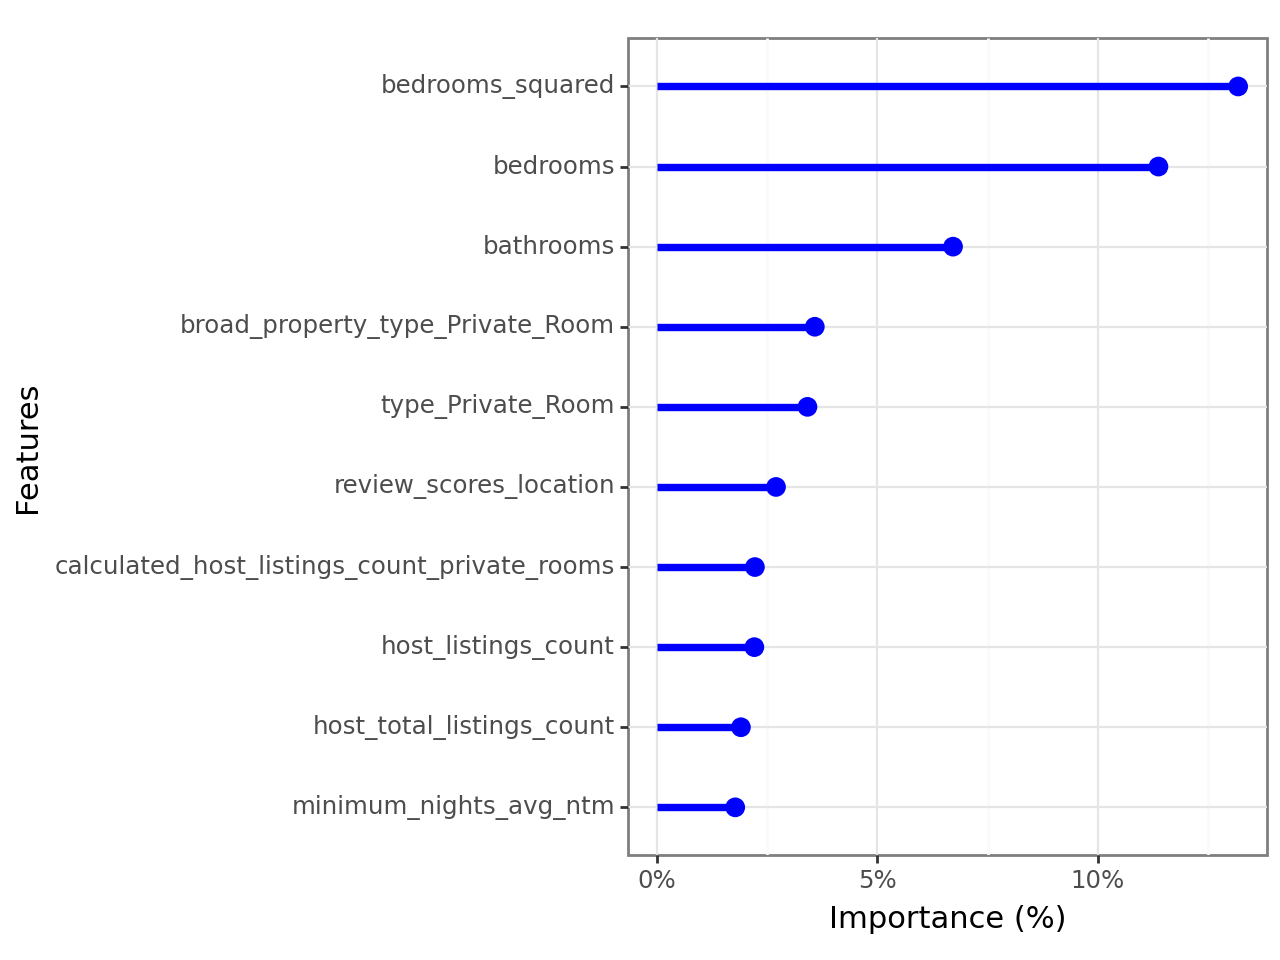

In [249]:
categorical_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine all feature names
feature_names = numeric_features.tolist() + categorical_feature_names.tolist()

# Extract feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# Create DataFrame with feature names and their importance scores
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Calculate importance percentage
importances_df['Importance (%)'] = (importances_df['Importance'] / importances_df['Importance'].sum())

# Plotting the Feature Importances
top_n = 10
plot = (
    ggplot(importances_df.head(top_n), aes(x='reorder(Feature, Importance)', y='Importance (%)')) +
    geom_point(color='blue', size=3) +
    geom_segment(aes(x='Feature', xend='Feature', y=0, yend='Importance (%)'), color='blue', size=1.5) +
    coord_flip() +
    scale_y_continuous(labels=percent_format()) +
    theme_bw() +
    ylab('Importance (%)') +
    xlab('Features')
)

plot.draw()

From the initial feature importance analysis, it is evident that the most influential variable is "bedrooms squared," accounting for approximately 13% of the model's predictive power, closely followed by "bedrooms" at about 11.5%. Subsequent to these, "bathrooms" emerges as another significant predictor.

In [250]:
listings.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_li

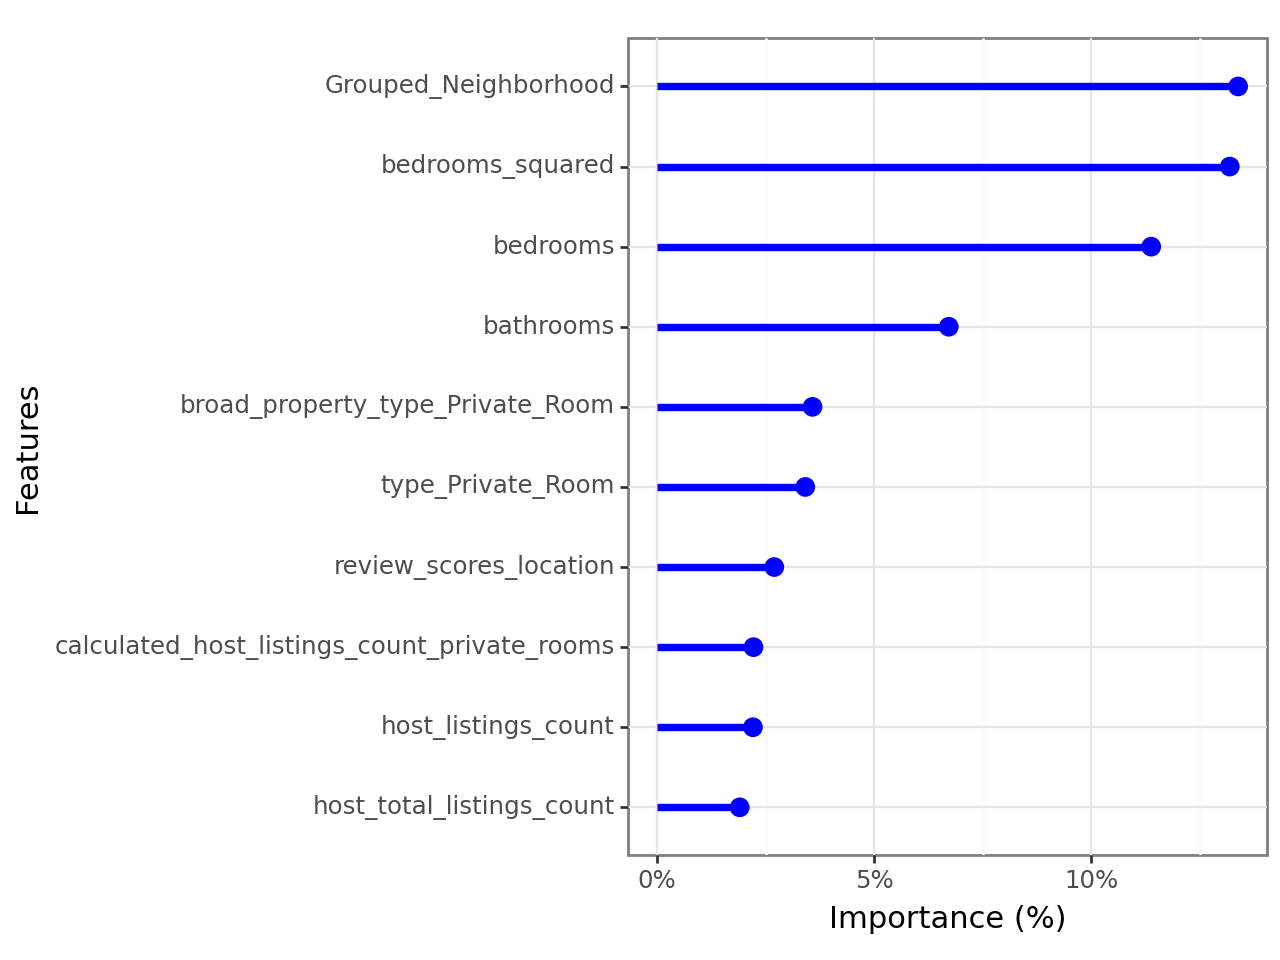

In [252]:
# Identify all neighborhood-related features
neighborhood_features = [col for col in importances_df['Feature'] if col.startswith('neighbourhood_')]

# Sum the importance of neighborhood features
neighborhood_importance_sum = importances_df[importances_df['Feature'].isin(neighborhood_features)]['Importance'].sum()

# Create a new row for the aggregated neighborhood importance
neighborhood_row = pd.DataFrame({
    'Feature': ['Grouped_Neighborhood'],
    'Importance': [neighborhood_importance_sum],
    'Importance (%)': [neighborhood_importance_sum / importances_df['Importance'].sum()]
})

# Remove individual neighborhood features from the original DataFrame
importances_df = importances_df[~importances_df['Feature'].isin(neighborhood_features)]

# Append the grouped neighborhood row
importances_df = pd.concat([importances_df, neighborhood_row], ignore_index=True).sort_values(by='Importance', ascending=False)

# Recalculate the importance percentage to ensure it sums to 100%
importances_df['Importance (%)'] = (importances_df['Importance'] / importances_df['Importance'].sum())

# Plotting the updated Feature Importances including Grouped Neighborhood
top_n = 10  # You can adjust this value as needed
plot = (
    ggplot(importances_df.head(top_n), aes(x='reorder(Feature, Importance)', y='Importance (%)')) +
    geom_point(color='blue', size=3) +
    geom_segment(aes(x='Feature', xend='Feature', y=0, yend='Importance (%)'), color='blue', size=1.5) +
    coord_flip() +
    scale_y_continuous(labels=percent_format()) +
    theme_bw() +
    ylab('Importance (%)') +
    xlab('Features')
)

plot.draw()

Upon consolidating neighborhoods into a single variable, the analysis yields a slightly altered outcome. The updated feature importance visualization reveals that the aggregated "neighborhood" variable now stands as the most critical predictor, contributing approximately 14% to the model's efficacy, with "bedrooms squared" closely behind at around 13%. "Bedrooms" and "bathrooms" continue to be important, following these leading features.

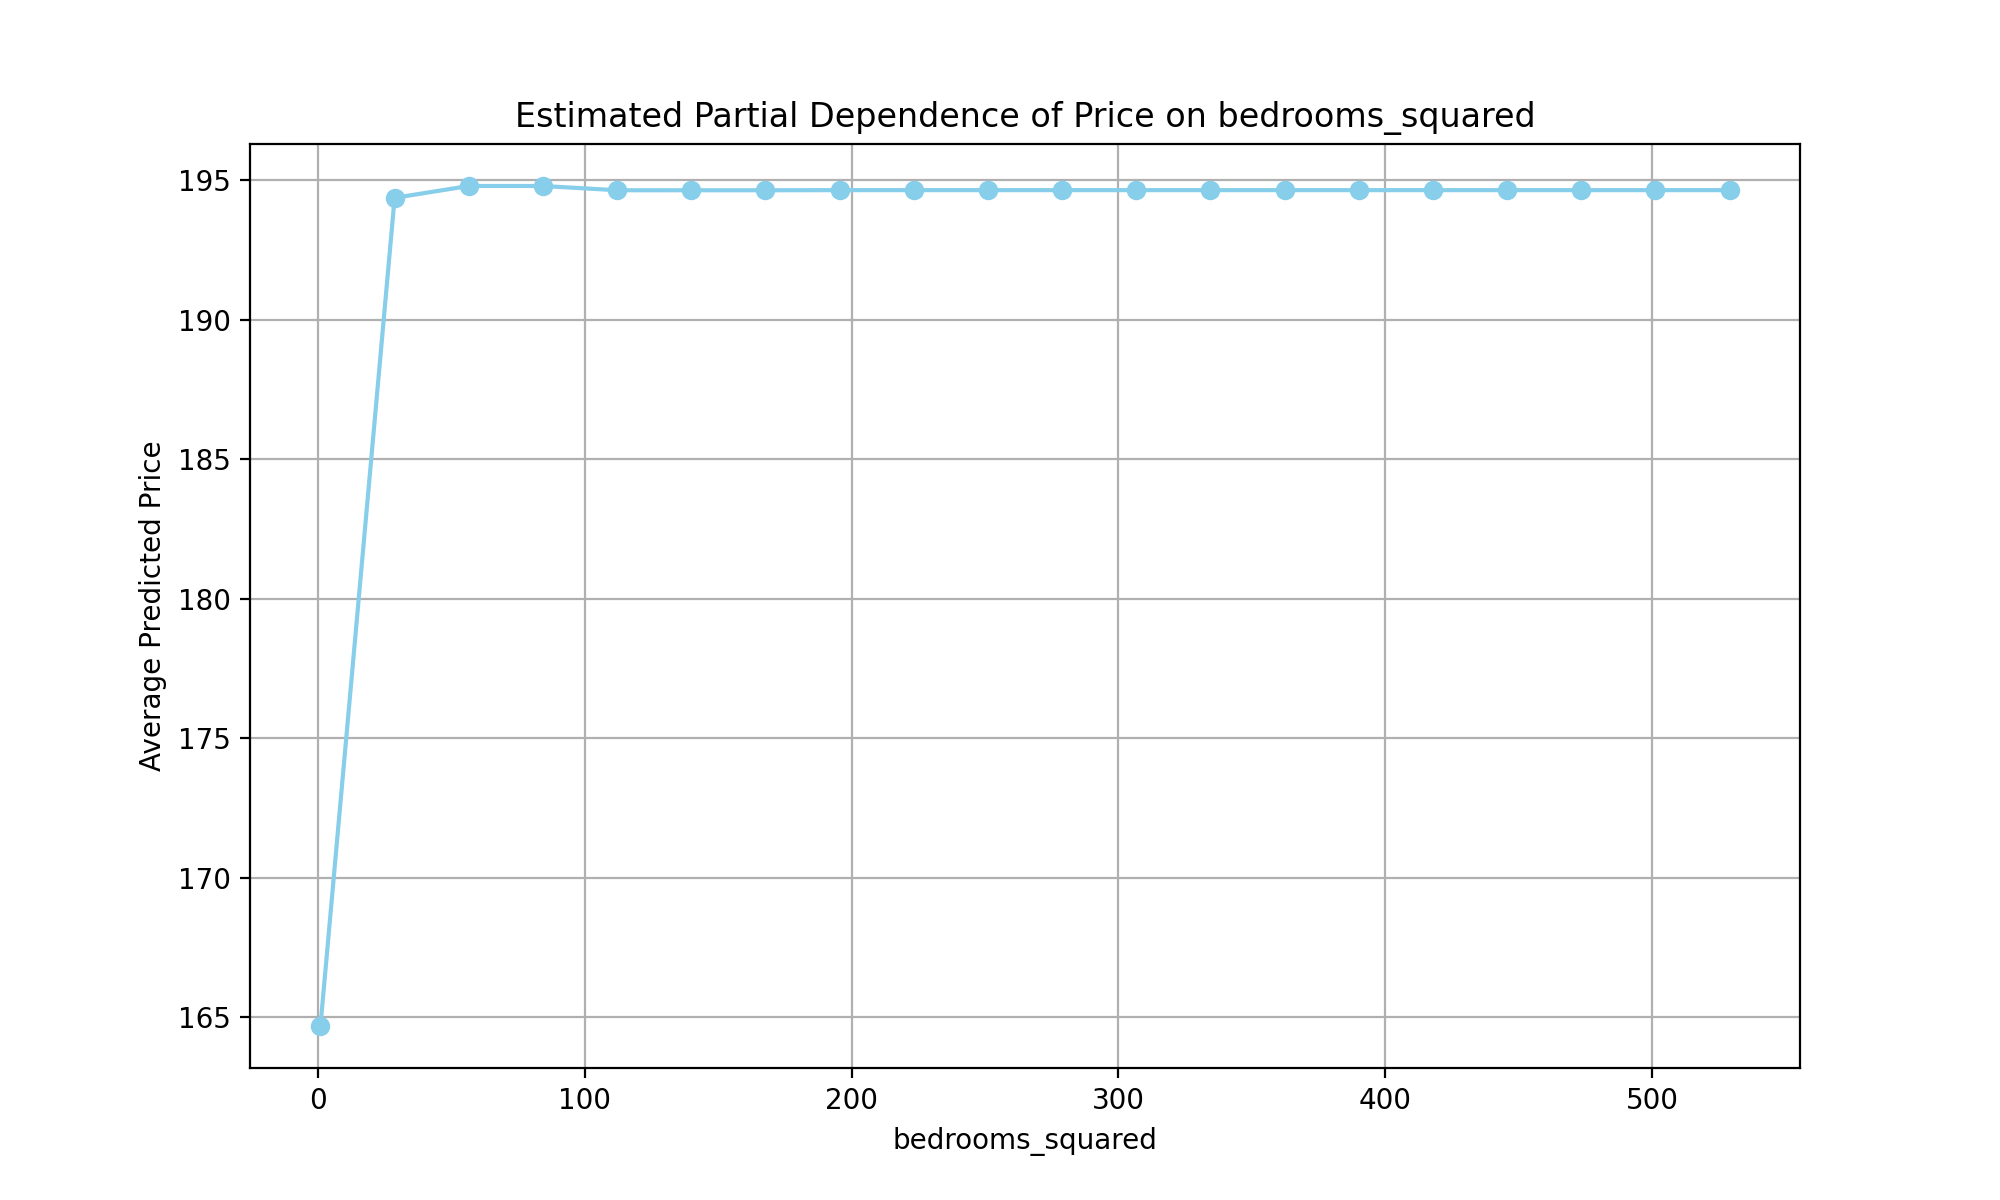

In [256]:
# Choose a feature and a range of values to analyze
feature = 'bedrooms_squared'
values_to_test = np.linspace(start=min(X_train[feature]), stop=max(X_train[feature]), num=20)

# Store average predictions for each feature value
avg_predictions = []

for value in values_to_test:
    # Create a copy of the X_test dataset
    modified_X_test = X_test.copy()
    
    # Set the feature of interest to a specific value across the entire dataset
    modified_X_test[feature] = value
    
    # Make predictions with the modified dataset
    predictions = model.predict(modified_X_test)
    
    # Convert predictions back from log scale if necessary
    predictions = np.exp(predictions)  # Comment out if your target variable isn't log-transformed
    
    # Store the average prediction
    avg_predictions.append(predictions.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(values_to_test, avg_predictions, marker='o', linestyle='-', color='skyblue')
plt.title(f'Estimated Partial Dependence of Price on {feature}')
plt.xlabel(feature)
plt.ylabel('Average Predicted Price')
plt.grid(True)
plt.show()

The analysis reveals a positive correlation between price and the square of the number of bedrooms up to a certain point. Specifically, this upward trend plateaus around the value of 30 for bedrooms squared. Converting this back to the original scale of bedrooms, this threshold corresponds to approximately 6 bedrooms. This suggests that beyond 6 bedrooms, the increase in the number of bedrooms does not significantly affect the price, indicating that the price largely stabilizes for properties with more than 6 bedrooms.

In [257]:
listings.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_li

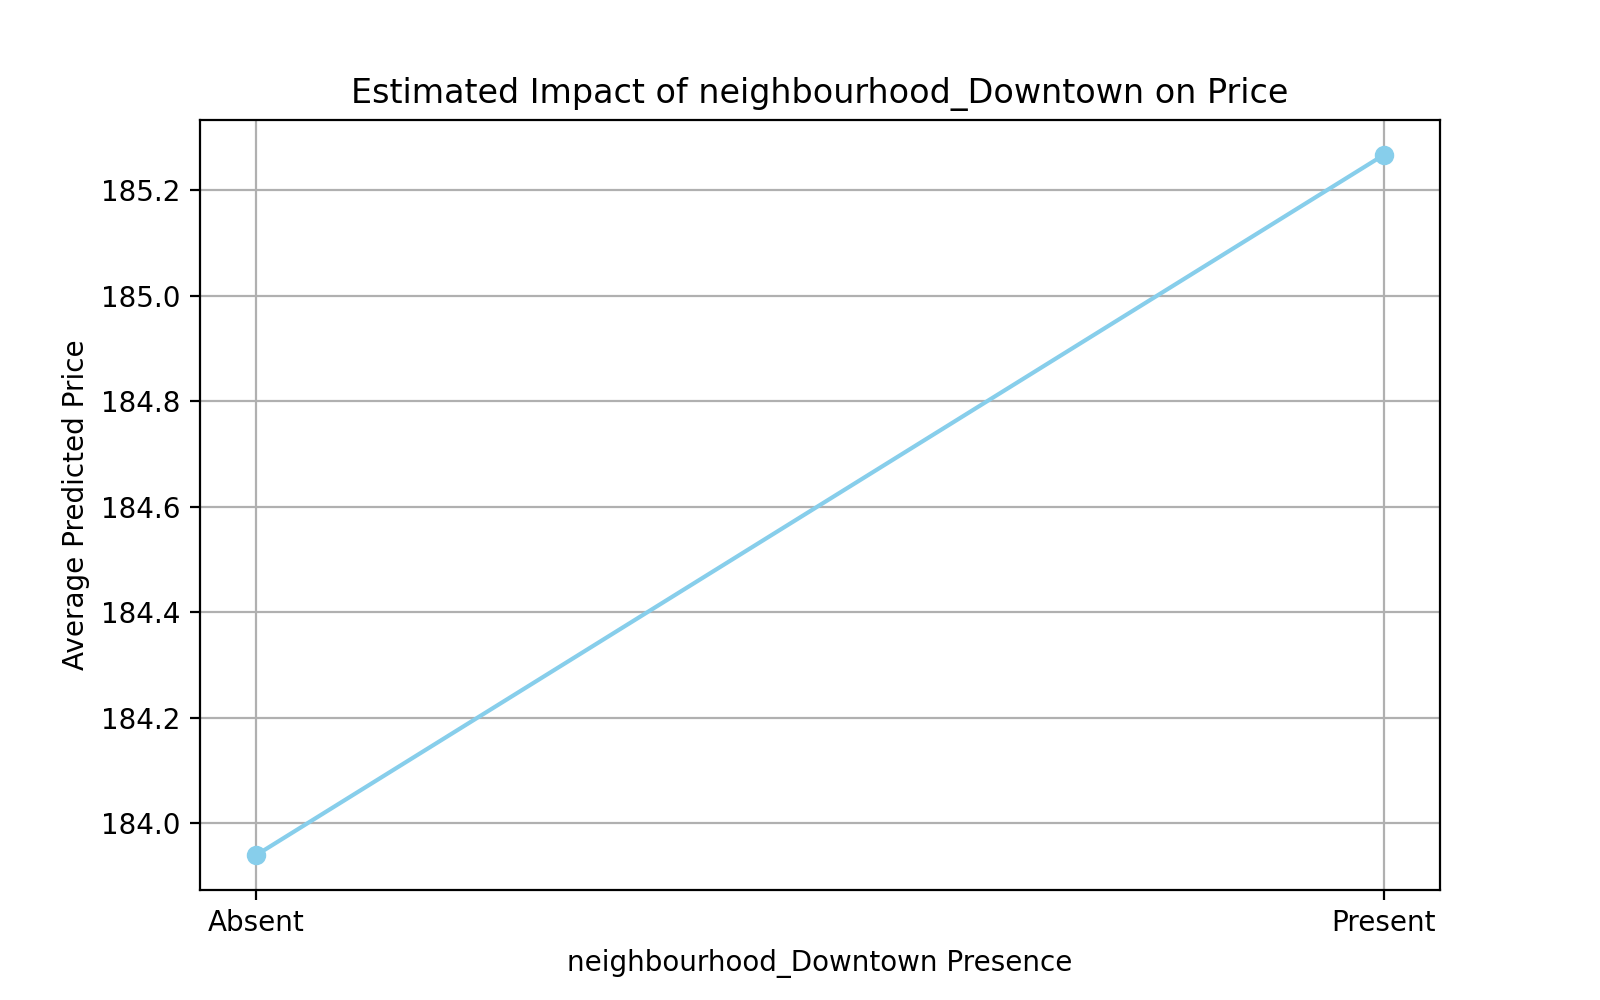

In [262]:
feature = 'neighbourhood_Downtown'  # Example

# Values to test: Absence (0) and presence (1) of the feature
values_to_test = [0, 1]

# Store average predictions for each feature value
avg_predictions = []

for value in values_to_test:
    # Create a copy of the X_test dataset
    modified_X_test = X_test.copy()
    
    # Set the feature of interest to the specific value across the entire dataset
    modified_X_test[feature] = value
    
    # Make predictions with the modified dataset
    predictions = model.predict(modified_X_test)
    
    # Optionally, convert predictions back from log scale if necessary
    predictions = np.exp(predictions)  # Uncomment/adjust if your target variable is log-transformed
    
    # Store the average prediction
    avg_predictions.append(predictions.mean())

# Plotting the results to approximate Partial Dependence for the "Grouped Neighborhood"
plt.figure(figsize=(8, 5))
plt.plot(values_to_test, avg_predictions, marker='o', linestyle='-', color='skyblue')
plt.title(f'Estimated Impact of {feature} on Price')
plt.xlabel(f'{feature} Presence')
plt.ylabel('Average Predicted Price')
plt.xticks(values_to_test, ['Absent', 'Present'])  # Adjust tick labels for clarity
plt.grid(True)
plt.show()

### Conclusion

In [272]:
model_comparison = pd.DataFrame({
    'Model': ['OLS', 'Lasso', 'Random Forest'],
    'RMSE': [average_rmse_cv, best_exp_rmse, rmse_level],
    'Average_y': [ols_average_y, lasso_average_y, average_predicted_price],
    'RMSE/Average_y': [ols_rmse_cv_to_avg_y_ratio, lasso_rmse_to_avg_y_ratio, random_forest_ratio]
})

model_comparison

,Model,RMSE,Average_y,RMSE/Average_y
0,OLS,421.611477,216.014739,1.951772
1,Lasso,416.332300,214.225692,1.943428
2,Random Forest,263.810623,184.086091,1.433083


The comparison of OLS, Lasso, and Random Forest models reveals notable differences in their predictive performance on the dataset. While the OLS and Lasso models show similar RMSE values, with OLS at approximately 421.61 and Lasso slightly lower at 416.33, indicating the average distance from the model predictions to the actual prices, the Random Forest model significantly outperforms both with an RMSE of 263.81. This suggests that the Random Forest model, with its complex decision trees and ability to capture non-linear relationships, provides a more accurate prediction of prices. The average predicted price (Average_y) is highest for the OLS model at 216.01, followed closely by Lasso at 214.23, and is lowest for the Random Forest model at 184.09, which could imply a more conservative estimation by the Random Forest model. The RMSE/Average_y ratio, which offers insight into the error relative to the scale of price predictions, is highest for the OLS model (1.95) and slightly lower for the Lasso model (1.94), indicating a proportionally similar predictive error relative to their average price predictions. In contrast, the Random Forest model achieves a lower ratio of 1.43, underscoring its superior predictive accuracy and efficiency in modeling the given dataset. This analysis underscores the effectiveness of ensemble methods like Random Forest in handling complex datasets and achieving more accurate predictions compared to linear models, especially in scenarios with diverse and non-linearly related predictive features.

For a company targeting small to mid-size apartments hosting 2-6 guests in Los Angeles, our analysis through the Random Forest model provides a solid foundation for pricing strategy. Given the model's average predicted price of approximately $184.09, with a notably lower RMSE to average price ratio of 1.43 compared to other models, it suggests an optimal pricing range that could enhance market competitiveness while ensuring profitability. Implementing this pricing strategy, especially in a diverse market like Los Angeles, could help in accurately pricing new apartments not yet on the market, catering to a wide array of customer preferences and market demands. This data-driven approach enables the company to strategically position its offerings, potentially leading to increased occupancy rates and maximized revenue.